# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [96]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16,9)

# Plotting config
%pylab inline

%load_ext pycodestyle_magic

Populating the interactive namespace from numpy and matplotlib
The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

$Всего \ возможно:  \ \ \ \ \underbrace{k * k * ... * k}_{N} = k^N  \ \ \ \   разбиений \ множества \ из \ N \ элементов \ на \ k \ кластеров. $

На каждой итерации алгоритма меняется разбиение выборки на кластеры и пересчитываются центры кластеров, уменьшая таким
образом значение функционала:

$$Q = \sum_{n=1}^{N} \sum_{k=1}^{K} r_{n,k} ||x_n - \mu_k||^2 .$$

Если на какой-то итерации разбиение не поменялось по сравнению с предыдущим, то в этой итерации не поменяются и центры кластеров. А значит на следующей итерации тоже ничего не поменяется. Следовательно, сходимость функционала.

 
Разбиений  $<= k^N$, следовательно этим же значением ограничивается число итераций алгоритма.


Случай повторного попадания на то же самое разбиение и, следовательно, на те же пересчитанные центры через какое-то количество итераций исключается тем, что каждое новое разбиение и связанный с ним пересчёт центров минимизируют функционал.
А в таком случае мы вновь придём к этому же значению функционала, что противоречит идее его минимизации.  


Задача 2.  ММП для многомерного нормального распределения.

Функция правдоподобия в общем случае записывается как:
￼
￼$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$
￼

***Ваше решение здесь***

$$ \mu = \frac{1}{N} \sum_{i=1}^{N} x_i$$

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

1) Первая формула


Очевидно, что $d_{\min}(U \cup V, S) = min(d_{\min}(U, S), d_{\min}(V, S))$ 


Возможно три случая:
<ol>
    <li>
$d_{\min}(U, S) < d_{\min}(V, S)$
        
то есть :  $d_{\min}(U \cup V, S) = d_{\min}(U, S)$, 

Получим это:

$d_{\min}(U, S) < d_{\min}(V, S) \Rightarrow \\ 
| d_{\min}(U, S) - d_{\min}(V, S) | =  - ( d_{\min}(U, S) - d_{\min}(V, S) ) =  d_{\min}(V, S) - d_{\min}(U, S)  \Rightarrow \\ \\
 \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  \\
=\frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} d_{\min}(V, S) + \frac{1}{2} d_{\min}(U, S) \\
= d_{\min}(U, S) = d_{\min}(U \cup V, S)$

</li>
<br><br>
<li>
$d_{\min}(U, S) > d_{\min}(V, S)$ 
    
Аналогично


</li>
<br>
<li>
    
$d_{\min}(U, S) = d_{\min}(V, S)$
    
то есть $d_{\min}(U \cup V, S) = d_{\min}(U, S) = d_{\min}(V, S)$, 

такое выражение очевидным образом получается из равенства нулю модуля
</li>
</ol>


<br>
2) Вторая формула


Очевидно, что $d_{\max}(U \cup V, S) = max(d_{\max}(U, S), d_{\max}(V, S))$

Рассмотрим случай: $d_{\max}(U, S) > d_{\max}(V, S)$, то есть:  $d_{\max}(U \cup V, S) = d_{\max}(U, S)$, 

Получим это:

$d_{\max}(U, S) > d_{\max}(V, S) \Rightarrow \\ 
| d_{\max}(U, S) - d_{\max}(V, S) | =  d_{\max}(U, S) - d_{\max}(V, S)  \Rightarrow \\ 
 \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  \\
=\frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} d_{\max}(U, S) - \frac{1}{2} d_{\max}(V, S) \\
= d_{\max}(U, S) = d_{\max}(U \cup V, S)$

Аналогично для случаев  $d_{\min}(U, S) > d_{\min}(V, S)$ и $d_{\min}(U, S) = d_{\min}(V, S)$.

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [144]:
# %%pycodestyle


from sklearn.base import BaseEstimator, ClusterMixin
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according
    """

    def __init__(self, metric, **kwargs):

        if metric == 'your_favourite_metric':
            metric = 'euclidean'
        self.metric = metric

        if 'method' in kwargs:
            self.method = kwargs['method']
        else:
            self.method = 'single'

        if 'n_clusters' in kwargs:
            self.n_clusters = kwargs['n_clusters']
        else:
            self.n_clusters = 2

        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """

        return

    def fit(self, X):
        n = len(X)
        cl_dists = squareform(pdist(X, self.metric))

        cluster = n

        clusters = np.array([np.arange(n)])
        linkage = []
        CL = clusters[0]

        i = 0
        while True:
            CL, CL_ind = np.unique(CL, return_index=True)
            cl_dists = cl_dists[np.ix_(CL_ind, CL_ind)]

            min_ind = cl_dists[np.eye(len(cl_dists)) == 0].argmin()
            min_ind = min_ind + min_ind // (cl_dists.shape[1] - 1) + 1
            nrst = np.unravel_index(min_ind, cl_dists.shape)

            min_dist = cl_dists[nrst]
            cl_0 = CL[nrst[0]]
            cl_1 = CL[nrst[1]]

            d0 = cl_dists[(CL != cl_0) * (CL != cl_1), CL == cl_0]
            d1 = cl_dists[(CL != cl_0) * (CL != cl_1), CL == cl_1]

            cl_lst, cl_count = np.unique(clusters[i], return_counts=True)
            union_sum = cl_count[cl_lst == cl_0][0] + \
                cl_count[cl_lst == cl_1][0]

            if self.method == 'single':
                a_0 = 1 / 2
                a_1 = 1 / 2
                c = -1 / 2
            elif self.method == 'complete':
                a_0 = 1 / 2
                a_1 = 1 / 2
                c = 1 / 2
            elif self.method == 'average':
                a_0 = cl_count[cl_lst == cl_0][0] / union_sum
                a_1 = cl_count[cl_lst == cl_1][0] / union_sum
                c = 0

            new_dist = a_0 * d0 + a_1 * d1 + c * np.absolute(d0 - d1)

            CL[CL == cl_0] = cluster
            CL[CL == cl_1] = cluster

            cl_dists[np.ix_(CL == cluster, CL != cluster)
                     ] = new_dist.reshape(1, -1)
            cl_dists[np.ix_(CL != cluster, CL == cluster)
                     ] = new_dist.reshape(-1, 1)

            cl_dists[np.ix_(CL == cluster, CL == cluster)] = 0

            clusters[i][clusters[i] == cl_0] = cluster
            clusters[i][clusters[i] == cl_1] = cluster

            linkage.append([cl_0, cl_1, min_dist, union_sum])

            cluster += 1

            if clusters[i].min() == clusters[i].max():
                self.linkage = linkage
                self.clusters = clusters
                return self

            clusters = np.append(clusters, [clusters[i]], axis=0)
            i += 1

    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """

        self.x_len = len(x)
        preds = pred_iris = [0] * self.x_len
        self.fit(x)

        preds = self.clusters[-self.n_clusters]
        for i in range(self.n_clusters):
            preds[preds == preds.max()] = i

        return preds

    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        dendrogram(self.linkage, leaf_rotation=90)
        plt.figure(figsize=(20, 10))
        plt.show()


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

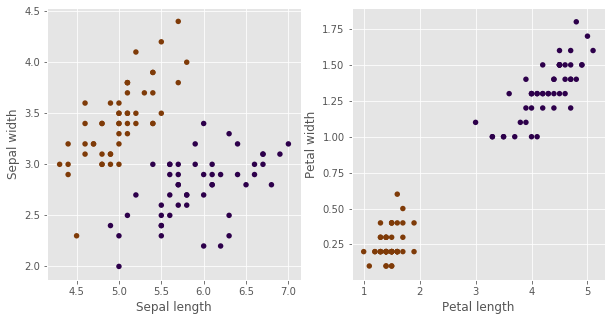

In [145]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [157]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
print(aggl_pred)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 Sklearn AGGL score 1.0. Sklearn AGGL time 0.009420633316040039


In [158]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='your_favourite_metric', method='single')
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
print(aggl_pred)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Our AGGL score 1.0. Our AGGL time 0.03719902038574219


# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

In [6]:
doc_to_title = {}
with open('docs_titles.tsv', encoding='utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [7]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [ ]:
# Место для Вашего кластерного анализа

1)Для предварительной обработки текста я использую nltk 
и стеммер Портера для русских слов (распологается в одной из ячеек снизу).

2)Для векторизованного представления слов 
я использую onehot-матрицу (либо модель Bag of Words, либо ещё с tfidf-преобразованием). 

In [10]:
import nltk
from nltk.stem import PorterStemmer
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfTransformer
PorterEnglish = PorterStemmer()
PorterRussian = PorterRussian()

def my_stem(word):
    if re.search(r'[а-яА-ЯёЁ]', word):
        return PorterRussian.stem(word)
    else:
        return PorterEnglish.stem(word)

In [162]:
# %%pycodestyle


def make_matrix(texts, mode=None):
    indptr = [0]
    column_indices = []
    values = []
    word_position = {}

    for text in texts:
        for word in text:
            index = word_position.setdefault(word, len(word_position))
            column_indices.append(index)
            values.append(1)
        indptr.append(len(column_indices))

    M = csr_matrix((values, column_indices, indptr), dtype=int)

    if mode == 'tfidf':
        trans = TfidfTransformer()
        trans.fit(M)
        M = trans.transform(M)

    elif mode == 'onehot':
        M[M != 0] = 1

    return M


In [206]:
# %%pycodestyle

# Функция для нахождения расстояний между заголовками


def f(x, y):
    union_cnt = ((x != 0) + (y != 0)).sum()
    if union_cnt == 0:
        return 0
    else:
        return 1 - ((x != 0) * (y != 0)).sum() / union_cnt


In [207]:
# %%pycodestyle
# Я проведу кластеризацию с разными параметрами в каждой из групп трейна


to_data = []
for group_id in traingroups_titledata:
    group = traingroups_titledata[group_id]
    X = [nltk.word_tokenize(
        re.sub(r'\W|\d', ' ', obj[1].lower())) for obj in group]
    X = [(list(map(lambda word: my_stem(word), x))) for x in X]
    y = [obj[2] for obj in group]
    y_true = np.array(y)

    for cl_method in ['single', 'complete', 'average']:
        M = make_matrix(X, "onehot").toarray()
        my = Clustering(metric=f, method=cl_method)
        y_pred = my.fit_predict(M)
        y_pred2 = np.zeros(len(y_pred), dtype=int)
        y_pred2[y_pred == 0] = 1
        f1_score = smt.f1_score(y_true, y_pred)
        f1_score2 = smt.f1_score(y_true, y_pred2)
        aggl_score = smt.adjusted_rand_score(y_true, y_pred)

        res = {}
        res['group_id'] = group_id
        res['matrix_mode'] = 'onehot'
        res['matrix_shape'] = M.shape
        res['clustering_method'] = my.method
        res['metric'] = 'f: % несовпадающих слов'
        res['f1_score_v1'] = f1_score
        res['f1_score_v2'] = f1_score2
        res['f1_score_max'] = max(f1_score, f1_score2)
        res['adjusted_rand_score'] = aggl_score
        to_data.append(res)

        M = make_matrix(X, 'tfidf').toarray()
        my = Clustering(metric='cosine', method=cl_method)
        y_pred = my.fit_predict(M)
        y_pred2 = np.zeros(len(y_pred), dtype=int)
        y_pred2[y_pred == 0] = 1
        f1_score = smt.f1_score(y_true, y_pred)
        f1_score2 = smt.f1_score(y_true, y_pred2)
        aggl_score = smt.adjusted_rand_score(y_true, y_pred)

        res = {}
        res['group_id'] = group_id
        res['matrix_mode'] = 'tfidf'
        res['matrix_shape'] = M.shape
        res['clustering_method'] = my.method
        res['metric'] = 'cosine'
        res['f1_score_v1'] = f1_score
        res['f1_score_v2'] = f1_score2
        res['f1_score_max'] = max(f1_score, f1_score2)
        res['adjusted_rand_score'] = aggl_score
        to_data.append(res)

        M = make_matrix(X, None).toarray()
        my = Clustering(metric='euclidean', method=cl_method)
        y_pred = my.fit_predict(M)
        y_pred2 = np.zeros(len(y_pred), dtype=int)
        y_pred2[y_pred == 0] = 1
        f1_score = smt.f1_score(y_true, y_pred)
        f1_score2 = smt.f1_score(y_true, y_pred2)
        aggl_score = smt.adjusted_rand_score(y_true, y_pred)

        res = {}
        res['group_id'] = group_id
        res['matrix_mode'] = 'bag of words'
        res['matrix_shape'] = M.shape
        res['clustering_method'] = my.method
        res['metric'] = 'euclidean'
        res['f1_score_v1'] = f1_score
        res['f1_score_v2'] = f1_score2
        res['f1_score_max'] = max(f1_score, f1_score2)
        res['adjusted_rand_score'] = aggl_score
        to_data.append(res)


C:\Users\gaziz\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [100]:
df = pd.DataFrame(to_data)

In [178]:
df.sort_values(by=['f1_score_max', 'adjusted_rand_score'],
               ascending=[False, False], inplace=True)


In [182]:
with open('experiment.csv', mode='w', encoding='utf-8') as f_csv:
    df.to_csv(f_csv, index=False)


In [105]:
df.head(10)

,adjusted_rand_score,clustering_method,f1_score_max,f1_score_v1,f1_score_v2,group_id,matrix_mode,matrix_shape,metric
1083,0.727513,complete,0.983784,0.983784,0.000000,121,onehot,"(99, 138)",f: % несовпадающих слов
684,-0.014906,single,0.979592,0.020408,0.979592,77,onehot,"(100, 148)",f: % несовпадающих слов
686,-0.014906,single,0.979592,0.020408,0.979592,77,bag of words,"(100, 148)",euclidean
689,-0.014906,complete,0.979592,0.020408,0.979592,77,bag of words,"(100, 148)",euclidean
692,-0.014906,average,0.979592,0.020408,0.979592,77,bag of words,"(100, 148)",euclidean
444,0.457878,complete,0.976190,0.000000,0.976190,50,onehot,"(88, 180)",f: % несовпадающих слов
685,-0.023806,single,0.974359,0.040404,0.974359,77,tfidf,"(100, 148)",cosine
690,-0.023806,average,0.974359,0.040404,0.974359,77,onehot,"(100, 148)",f: % несовпадающих слов
691,-0.023806,average,0.974359,0.040404,0.974359,77,tfidf,"(100, 148)",cosine
432,0.402851,single,0.973822,0.000000,0.973822,49,onehot,"(100, 188)",f: % несовпадающих слов


Построим дендрограмму для результата с f1_score = 0.983784 (из группы 121)

Для этого повторим процесс преподготовки и кластеризацию

In [187]:
# %%pycodestyle

group_id = 121
group = traingroups_titledata[group_id]
X = [nltk.word_tokenize(
    re.sub(r'\W|\d', ' ', obj[1].lower())) for obj in group]
X = [(list(map(lambda word: my_stem(word), x))) for x in X]
y = [obj[2] for obj in group]
y_true = np.array(y)


In [122]:
M = make_matrix(X, 'onehot').toarray()

In [195]:
# %%pycodestyle

my = Clustering(metric=f, method='complete')
y_pred = my.fit_predict(M)
print("PREDICTED:\n", y_pred)
print("TRUE:\n", y_true)

f1_score = smt.f1_score(y_true, y_pred)
aggl_score = smt.adjusted_rand_score(y_true, y_pred)
print("\nf1_score: {}. f1_score2: {}. aggl_score {}".format(
    f1_score, f1_score2, aggl_score))


PREDICTED:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
TRUE:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]

f1_score: 0.9837837837837838. f1_score2: 0.0. aggl_score 0.7275132636315729


Здесь алгоритм точно выявил точки аномалии, хоть и не полно:

In [199]:
np.argwhere(y_pred == 0)


array([[14],
       [33],
       [41],
       [55],
       [62]], dtype=int64)

In [200]:
np.argwhere(y_true == 0)


array([[14],
       [30],
       [33],
       [40],
       [41],
       [55],
       [62],
       [97]], dtype=int64)

<b> Linkage </b>

linkage - список с информацией о разбиениях на новые кластеры, который используется для построения дендрограммы

Рассмотрим его последние элементы

Можно заметить элементы 14, 33, 41, 55, 62 среди последних объединений в кластеры.

14, 33, 41, 55, 62 - номера кластеров-одиночек, так как нумерация кластеров больше, чем из одного элемента начинается с len(X). В данном случае len(X) = 99.



In [202]:
my.linkage[-13:]


[[14, 55, 0.875, 2],
 [40, 178, 0.8799999999999999, 3],
 [174, 176, 0.8888888888888888, 8],
 [182, 185, 0.8888888888888888, 16],
 [175, 177, 0.8947368421052633, 15],
 [181, 188, 0.9411764705882353, 22],
 [183, 186, 0.9444444444444444, 56],
 [187, 189, 0.9523809523809523, 38],
 [33, 41, 1.0, 2],
 [62, 184, 1.0, 3],
 [190, 191, 1.0, 94],
 [192, 193, 1.0, 5],
 [194, 195, 1.0, 99]]

<b> Дендрограмма </b>

И на дендрограмме наглядно их позднее объединение (справа). То есть они как бы до последнего не кластеризовались вообще ни с какими другими элементами, а затем попали в кластер выбросов.

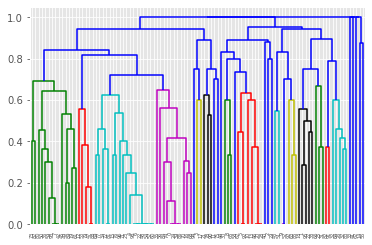

<Figure size 1440x720 with 0 Axes>

In [203]:
my.plot_dendrogram()


# Ответы на вопросы #

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?
Ответ дан выше.


2) Какое расстояние лучше использовать между заголовками страниц для кластеризации?
В моём исследовании лучше всего проявило себя расстояние, показывающее долю общих слов.


3) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)
0.983784


4) Как можно результат кластеризации затем использовать для финальной модели обучения с учителем?
Метку кластера можно использовать как дополнительный признак.

In [208]:
# Сторонний стеммер для русских слов

# %%pycodestyle


class PorterRussian:
    PERFECTIVEGROUND = re.compile(
        u"((ив|ивши|ившись|ыв|ывши|ывшись)|((?<=[ая])(в|вши|вшись)))$")
    REFLEXIVE = re.compile(u"(с[яь])$")
    ADJECTIVE = re.compile(
        u"(ее|ие|ые|ое|ими|ыми|ей|ий|ый|ой|ем|им|ым|ом|его|ого|ему|ому|их|ых|ую|юю|ая|яя|ою|ею)$")
    PARTICIPLE = re.compile(u"((ивш|ывш|ующ)|((?<=[ая])(ем|нн|вш|ющ|щ)))$")
    VERB = re.compile(
        u"((ила|ыла|ена|ейте|уйте|ите|или|ыли|ей|уй|ил|ыл|им|ым|ен|ило|ыло|ено|ят|ует|уют|ит|ыт|ены|ить|ыть|ишь|ую|ю)|((?<=[ая])(ла|на|ете|йте|ли|й|л|ем|н|ло|но|ет|ют|ны|ть|ешь|нно)))$")
    NOUN = re.compile(
        u"(а|ев|ов|ие|ье|е|иями|ями|ами|еи|ии|и|ией|ей|ой|ий|й|иям|ям|ием|ем|ам|ом|о|у|ах|иях|ях|ы|ь|ию|ью|ю|ия|ья|я)$")
    RVRE = re.compile(u"^(.*?[аеиоуыэюя])(.*)$")
    DERIVATIONAL = re.compile(u".*[^аеиоуыэюя]+[аеиоуыэюя].*ость?$")
    DER = re.compile(u"ость?$")
    SUPERLATIVE = re.compile(u"(ейше|ейш)$")
    I = re.compile(u"и$")
    P = re.compile(u"ь$")
    NN = re.compile(u"нн$")

    def stem(word):
        word = word.lower()
        word = word.replace(u'ё', u'е')
        m = re.match(PorterRussian.RVRE, word)
        if m and m.groups():
            pre = m.group(1)
            rv = m.group(2)
            temp = PorterRussian.PERFECTIVEGROUND.sub('', rv, 1)
            if temp == rv:
                rv = PorterRussian.REFLEXIVE.sub('', rv, 1)
                temp = PorterRussian.ADJECTIVE.sub('', rv, 1)
                if temp != rv:
                    rv = temp
                    rv = PorterRussian.PARTICIPLE.sub('', rv, 1)
                else:
                    temp = PorterRussian.VERB.sub('', rv, 1)
                    if temp == rv:
                        rv = PorterRussian.NOUN.sub('', rv, 1)
                    else:
                        rv = temp
            else:
                rv = temp

            rv = PorterRussian.I.sub('', rv, 1)

            if re.match(PorterRussian.DERIVATIONAL, rv):
                rv = PorterRussian.DER.sub('', rv, 1)

            temp = PorterRussian.P.sub('', rv, 1)
            if temp == rv:
                rv = PorterRussian.SUPERLATIVE.sub('', rv, 1)
                rv = PorterRussian.NN.sub(u'н', rv, 1)
            else:
                rv = temp
            word = pre + rv
        return word
    stem = staticmethod(stem)


Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***